# Imports

In [1]:
import os
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wa_parser
from os import path
from wordcloud import WordCloud, STOPWORDS

FILEPATH = r'./chats/chat.txt'
BACKGROUND_COLOR = 'white'
PRIMARY_COLOR = '#e76f51'
LOOKBACK_WEEKS = 104
ROLLING_INTERVAL = 14

plt.rcParams["figure.facecolor"] = BACKGROUND_COLOR
plt.rcParams["axes.facecolor"] = BACKGROUND_COLOR
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.left"] = False
plt.rcParams["axes.spines.bottom"] = False

# Data Loading

In [2]:
from visualizations_setup import DATEFORMAT, TIMEFORMAT
df = wa_parser.get_df_from_chatlog(FILEPATH, dateformat = DATEFORMAT, \
                        timeformat = TIMEFORMAT)
df = df[df['datetime'] > df['datetime'].max() - pd.Timedelta(weeks=LOOKBACK_WEEKS)]
df["hour"] = df["datetime"].dt.hour

# Visualizations

## Lineplot - Messages per Day

In [3]:
df_daily_mess = df.groupby(by=df['datetime'].dt.date)['message'].count().reset_index()
df_daily_mess["messsagecount_rm"] = df_daily_mess["message"].rolling(ROLLING_INTERVAL, 
                                                                     min_periods=3, center=True).mean()

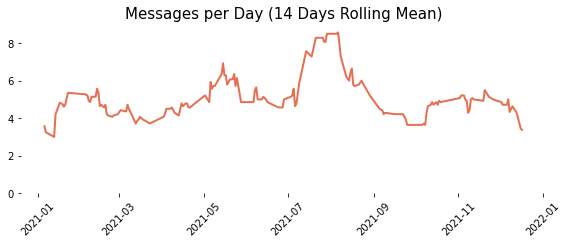

In [5]:
fig, ax = plt.subplots(figsize=(8, 3.5))
sns.lineplot(data=df_daily_mess, x='datetime', y='messsagecount_rm',
             ax=ax, color=PRIMARY_COLOR, lw=2)
ax.set_ylim(0, np.ceil(max(df_daily_mess['messsagecount_rm'].values)))
# ax.set_xlim([datetime.date(2019, 11, 1), datetime.date(2021, 12, 1)])
ax.tick_params(axis='x', rotation=45)
ax.set_title(f"Messages per Day ({ROLLING_INTERVAL} Days Rolling Mean)", fontdict={"fontsize": 15})
ax.set_xlabel(None)
ax.set_ylabel(None)
#plt.legend(frameon = False, bbox_to_anchor=(1.04,0.5), loc="center left")
plt.tight_layout()

## Sunburstchart - Messages per Daytime

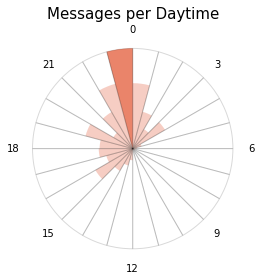

In [6]:
df_circle = df.groupby(by='hour')['message'].count().reset_index()

time = df_circle['hour']
count = df_circle['message']

c = np.zeros(24)
c[time] = count
count = c

f = plt.figure(figsize=(8, 4))
ax = plt.subplot(111, projection="polar")

x = np.arange(0, 2 * np.pi, 2 * np.pi / len(count)) + np.pi / len(count)

bars = ax.bar(x, count, width=2 * np.pi / len(count),
              alpha=0.4, color=PRIMARY_COLOR, bottom=0)

max_ind = np.argmax(count)
ax.bar(x[max_ind],count[max_ind], bottom=0,
       width=2 * np.pi / len(count), alpha=1, color=PRIMARY_COLOR)

ax.bar(x, np.max(count) * np.ones(len(count)), width=2 * np.pi / len(count),
    alpha=0.15, bottom=0, color=BACKGROUND_COLOR, edgecolor="black")

ax.set_theta_direction(-1)
ax.grid(False)
ax.spines["polar"].set_visible(False)
ax.set_theta_offset(np.pi / 2)
ax.set_xticks(np.linspace(0, 2 * np.pi, 24, endpoint=False))
ticks = ["0", "", "", "3", "", "", "6", "", "", "9",
         "", "", "12", "", "", "15", "", "", "18", "", "",
         "21", "", ""]
ax.set_xticklabels(ticks)
ax.set_title("Messages per Daytime", fontdict={"fontsize": 15})
plt.setp(ax.get_yticklabels(), visible=False)
plt.tight_layout()

## WordCloud

In [7]:
from visualizations_setup import MEDIA_FLAG

messages = [word.split() for word in df["message"].values if not MEDIA_FLAG in word]
words = [word.lower() for sublist in messages for word in sublist]

stopwords = STOPWORDS.update(['media', 'omitted', 'missed', 'voice', 'call', 'http', 'https'])

In [8]:
import spacy
nlp = spacy.load('de_core_news_sm')
lemmatized_words = []
for token in nlp(" ".join(words)):
    lemmatized_words += [token.lemma_]

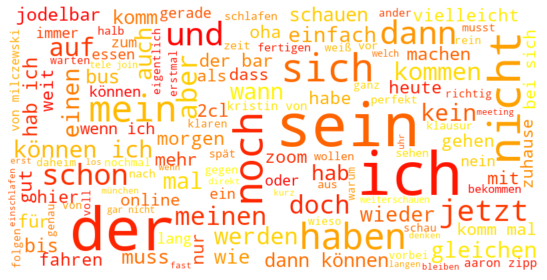

In [9]:
wordcloud = WordCloud(stopwords=stopwords, max_font_size=90, width=800, height=400,
                      background_color=BACKGROUND_COLOR, colormap='autumn', min_word_length=3,
                      max_words=400, min_font_size=12).generate(' '.join(lemmatized_words))
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()

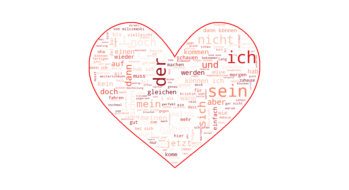

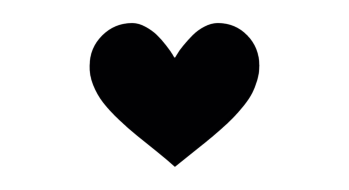

In [10]:
from mask import create_masked
create_masked(" ".join(lemmatized_words), "wc_heart")

In [11]:
from visualizations_setup import is_emoji, split_count
emoji_list = [word for word in words if any(is_emoji(char) for char in word)]
emoji_count = split_count(str.join(" ", emoji_list))
em = []
for key, value in emoji_count.items():
    for _ in range(value):
        em.append(key)
em

from visualizations_setup import replacements
emoji_text = " ".join(em)
for key, value in replacements.items():
    emoji_text = emoji_text.replace(key, value)

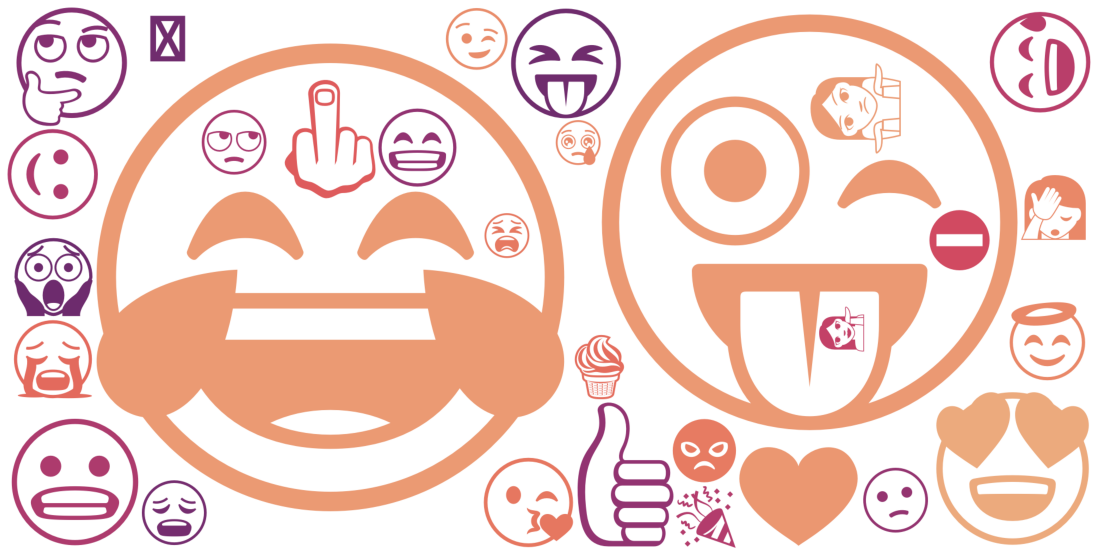

In [12]:
from visualizations_setup import EmojiCloud, FONT_PATH
emoji_cloud = EmojiCloud(font_path = FONT_PATH)
emoji_cloud.generate(emoji_text)

##### Statistics

Total Words

In [13]:
df["words"].sum()

4206

Total Messages

In [14]:
df.count()

weekday     792
datetime    792
author      792
message     792
words       792
letters     792
hour        792
dtype: int64

Avg. Words per Message

In [15]:
df["words"].sum()/df.count()

weekday     5.310606
datetime    5.310606
author      5.310606
message     5.310606
words       5.310606
letters     5.310606
hour        5.310606
dtype: float64

Unique Words

In [16]:
messages = [word.split() for word in df["message"].values]
words = [word.lower() for sublist in messages for word in sublist]
len(set(words))

1427